<a href="https://colab.research.google.com/github/armiro/Pneumothorax-Segmentation/blob/master/pnx_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import glob, cv2, gzip, gc

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, concatenate, Lambda
from tensorflow.keras import Model, backend as K, callbacks as cb

In [2]:
# load the dataset
path = '/content/drive/MyDrive/Datasets/siim_acr_pneumothorax_seg/'
img_file = gzip.GzipFile(filename=path+'training_images.npy.gz', mode='r')
%time images = np.load(file=img_file)
msk_file = gzip.GzipFile(filename=path+'training_masks_resized.npy.gz', mode='r')
%time masks = np.load(file=msk_file)
metadata = pd.read_csv(filepath_or_buffer=path+'converted-train-rle.csv', index_col=None)
age = metadata.loc[:, 'PatientAge']
sex = metadata.loc[:, 'PatientSex']
view = metadata.loc[:, 'ImageView']

print('metadata columns:', metadata.columns)
print('shape of the dataset:', images.shape)
print('shape of the masks:', masks.shape)

CPU times: user 27.2 s, sys: 1.38 s, total: 28.6 s
Wall time: 54.9 s
CPU times: user 8.39 s, sys: 1.39 s, total: 9.78 s
Wall time: 9.82 s
metadata columns: Index(['ImageId', 'PatientId', 'PatientAge', 'PatientSex', 'ImageView'], dtype='object')
shape of the dataset: (12047, 512, 512)
shape of the masks: (12047, 512, 512)


In [ ]:
# because of memory limit, manual data splitter is defined so that we can split 
# images and masks in different steps and delete unnecessary variables in between
def manual_train_test_split(data, test_ratio, init_indices):
    if init_indices is not None:
        shuffle_indices = init_indices
    else:
        shuffle_indices = np.random.permutation(len(data))
    test_size = int(test_ratio * len(data))
    test_indices = shuffle_indices[:test_size]
    train_indices = shuffle_indices[test_size:]
    return data[train_indices], data[test_indices], shuffle_indices


images = np.expand_dims(images, axis=-1)
X_train, X_val, indices = manual_train_test_split(data=images, test_ratio=0.2, init_indices=None)
del images
gc.collect()

masks = np.expand_dims(masks, axis=-1)
y_train, y_val, _ = manual_train_test_split(data=masks, test_ratio=0.2, init_indices=indices)
del masks
gc.collect()

In [4]:
# define metrics: dice coefficient (DICE/F1-score) and intersection over union (IoU/Jaccard)
def dice_coef(y_true, y_pred, smooth=1):
    overlap = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    total_area = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    dsc = K.mean((2.0 * overlap + smooth) / (total_area + smooth), axis=0)
    return dsc


def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

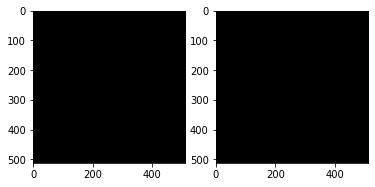

inter-dice is: tf.Tensor(1.0, shape=(), dtype=float64) and inter-jaccard is: tf.Tensor(1.0, shape=(), dtype=float64)
self-dice is: tf.Tensor(1.0, shape=(), dtype=float64) and self-jaccard is: tf.Tensor(1.0, shape=(), dtype=float64)


In [5]:
# test masks to see if both DSC ans IoU metrics are working correctly
im1 = np.expand_dims(y_train[2], axis=0).astype('float64')
im2 = np.expand_dims(y_train[29], axis=0).astype('float64')

plt.subplot(1, 2, 1)
plt.imshow(X=np.squeeze(im1, axis=(0, -1)), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(X=np.squeeze(im2, axis=(0, -1)), cmap='gray')
plt.show()

print('inter-dice is:', dice_coef(im1, im2), 'and inter-jaccard is:', iou_coef(im1, im2))
print('self-dice is:', dice_coef(im1, im1), 'and self-jaccard is:', iou_coef(im1, im1))

In [ ]:
# model architecture: vanilla unet
def vanilla_unet(input_size=(512,512,1)):
    inputs = Input(input_size)
    ds_inputs = Lambda(lambda image: image/255.0, name='down_scaler')(inputs)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(ds_inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10], name='segmentor')


model = vanilla_unet(input_size=(512, 512, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef, iou_coef])
model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True)

In [7]:
# define training callbacks
checkpoint = cb.ModelCheckpoint('/content/drive/My Drive/pnx_model/eps={epoch:03d}_valLoss={val_loss:.4f}.hdf5',
                                monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cb_list = [checkpoint]

In [ ]:
training = model.fit(x=X_train, y=y_train, batch_size=24, epochs=1, verbose=1,
                     steps_per_epoch=len(X_train)//24.0, validation_data=(X_val, y_val),
                     callbacks=cb_list)

fig = plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(training.history['loss'], color='r', label='training_loss')
plt.plot(training.history['val_loss'], color='g', label='validation_loss')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(training.history['dice_coef'], color='r', label='training_dsc')
plt.plot(training.history['val_dice_coef'], color='g', label='validation_dsc')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(training.history['iou_coef'], color='r', label='training_iou')
plt.plot(training.history['val_iou_coef'], color='g', label='validation_iou')
plt.legend()
plt.show()
fig.savefig('/content/drive/My Drive/pnx_model/training.png', bbox_inches='tight')

 63/401 [===>..........................] - ETA: 5:48 - loss: 0.0918 - dice_coef: 0.0031 - iou_coef: 0.0024

In [ ]:
idx = 17

plt.imshow(X=X_train[idx].squeeze(), cmap='bone')
plt.show()
plt.imshow(X=y_train[idx].squeeze(), cmap='gray')
plt.show()
pred = model.predict(np.expand_dims(X_train[idx], axis=0))
plt.imshow(X=np.squeeze(pred, axis=(0, -1)), cmap='gray')
plt.show()